In [3]:
import requests
import pandas as pd

In [1]:
import pmdarima as pm
import pandas as pd
import os
#getting baseline model
df=pd.read_csv('IBM.csv', index_col=0, parse_dates=True)
y = df['close']
model = pm.auto_arima(y, start_p=1, start_q=1, 
                              max_p=5, max_q=5, 
                              seasonal=False, 
                              stepwise=True, 
                              trace=True, 
                              suppress_warnings=True,
                              error_action='ignore', 
                              maxiter=100)

summary = model.summary()
print(summary)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=26649.071, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=26647.999, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=26647.081, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=26647.088, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=26646.538, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.270 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 6297
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -13322.269
Date:                Sun, 10 Nov 2024   AIC                          26646.538
Time:                        14:14:43   BIC                          26653.286
Sample:                             0   HQIC                         26648.875
                               - 6297                                  

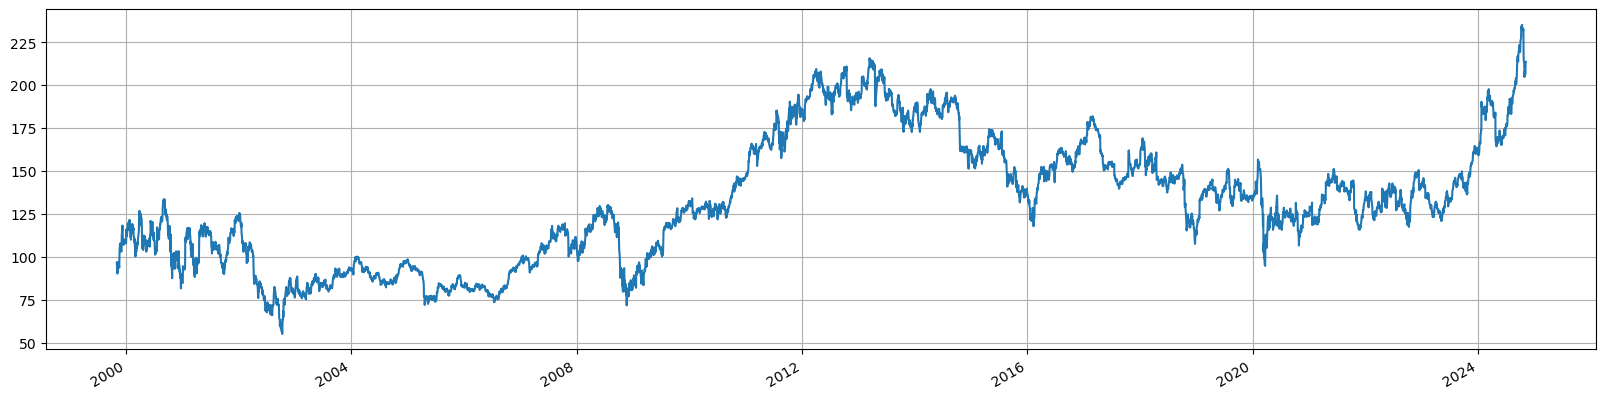

In [4]:
from pylab import rcParams
import statsmodels.api as sm
import matplotlib.pyplot as plt
import ta
#scraping data
key='GWQKZHTD2RXCTUDD'
url=f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=IBM&apikey={key}&outputsize=full"
response=requests.get(url)
if response.status_code == 200:
  data=response.json()
  if "Time Series (Daily)" in data:
    time_series = data["Time Series (Daily)"]
    df = pd.DataFrame.from_dict(time_series, orient="index")
    df.columns = ["open", "high", "low", "close", "volume"]
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    df = df.apply(pd.to_numeric)
    Z= df
    Z['7_day_std'] = Z['close'].rolling(window=7).std()
    Z['7_SMA'] = Z['close'].rolling(window=7).mean()
    Z['14_EMA'] = Z['close'].ewm(span=14, adjust=False).mean()
    Z['DMI_plus'] = ta.trend.adx_pos(Z['high'], Z['low'], Z['close'], window=14)
    Z['DMI_minus'] = ta.trend.adx_neg(Z['high'], Z['low'], Z['close'], window=14)
    Z['ATR'] = ta.volatility.AverageTrueRange(Z['high'], Z['low'], Z['close'], window=14).average_true_range()
    Z['MACD'] = ta.trend.MACD(Z['close']).macd()
    Z['MACD_Signal'] = ta.trend.MACD(Z['close']).macd_signal()
    stoch = ta.momentum.StochasticOscillator(Z['high'], Z['low'], Z['close'], window=14, smooth_window=3)
    Z['stoch_k'] = stoch.stoch()
    Z['stoch_d'] = stoch.stoch_signal()
    Z['close_change'] = Z['close'].pct_change()
    df.to_csv('IBM.csv', index=True)
  else:
    print(f"Time Series data for IBM is missing or unavailable.")
x=Z['close']
x.plot(grid=True,figsize=(20,5))
plt.show()

In [249]:
data=df['close']
print(data)
print(data.isnull().sum())  #check for NaN in data


Unnamed: 0
1999-11-02   -1.94
1999-11-03   -0.44
1999-11-04   -2.81
1999-11-05   -1.31
1999-11-08    3.69
              ... 
2024-10-25   -3.72
2024-10-28   -1.76
2024-10-29   -2.48
2024-10-30   -5.53
2024-10-31    1.82
Name: close, Length: 6290, dtype: float64
0


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.47252D+00    |proj g|=  5.42023D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   8.169D-06   2.473D+00
  F =   2.4725197579665883     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
MAPE: 289903.748%
MPE: -289213.525%
RMSE: 2.891
Explained Variance: 0.000
MAE 2.005


/Users/marieqi/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/marieqi/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/marieqi/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/marieqi/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model

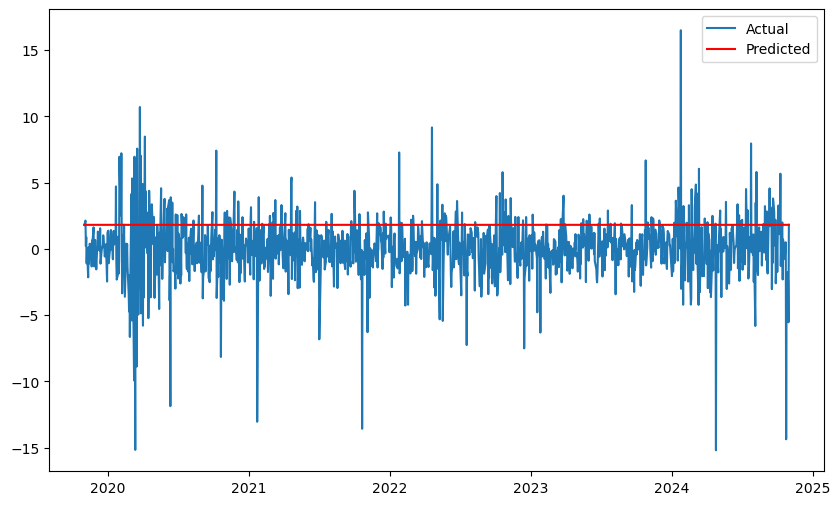

In [253]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
#plot the arima results and forecast
from sklearn.metrics import explained_variance_score
train_size = int(len(data) * 0.8)
train,test = data[:train_size], data[train_size:]
arima = SARIMAX(data, order=(0,1,0))
model = arima.fit()
prediction = model.forecast(1258)
mae = np.mean(np.abs(model.resid))
residuals = test - prediction
actual_values=test
prediction.index=test.index
mape = np.mean(np.abs((actual_values - prediction) / (actual_values + 1e-6))) * 100 
mpe = np.mean((actual_values - prediction) / (actual_values + 1e-6)) * 100 
rmse = np.sqrt(np.mean((actual_values - prediction) ** 2))
explained_var=explained_variance_score(test,prediction)
print(f"MAPE: {mape:.3f}%")
print(f"MPE: {mpe:.3f}%")
print(f"RMSE: {rmse:.3f}")
print(f"Explained Variance: {explained_var:.3f}")
print('MAE %.3f'%mae)
plt.figure(figsize=(10, 6))
plt.plot(test, label="Actual")
plt.plot(test.index,prediction, label="Predicted", color='red')
plt.legend()
plt.show()



In [7]:
print(df['close'])

1999-11-01     96.75
1999-11-02     94.81
1999-11-03     94.37
1999-11-04     91.56
1999-11-05     90.25
               ...  
2024-11-04    206.32
2024-11-05    207.57
2024-11-06    213.60
2024-11-07    213.69
2024-11-08    213.72
Name: close, Length: 6297, dtype: float64


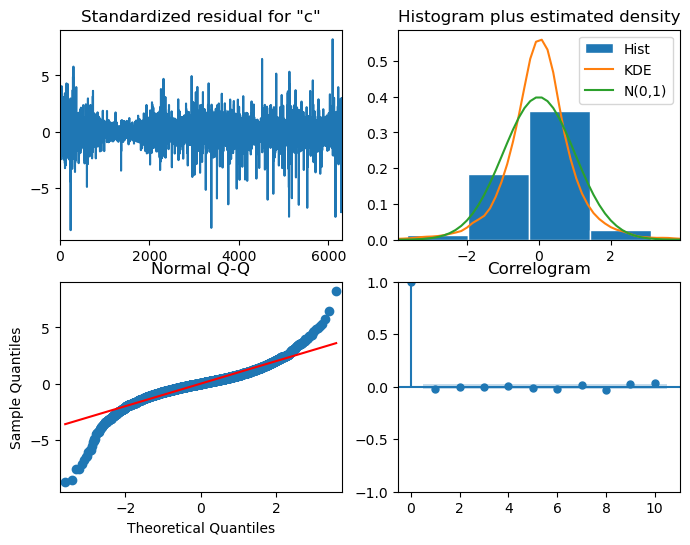

In [8]:
plt.figure
#model diagnostics
model.plot_diagnostics(figsize=(8, 6))
plt.show()


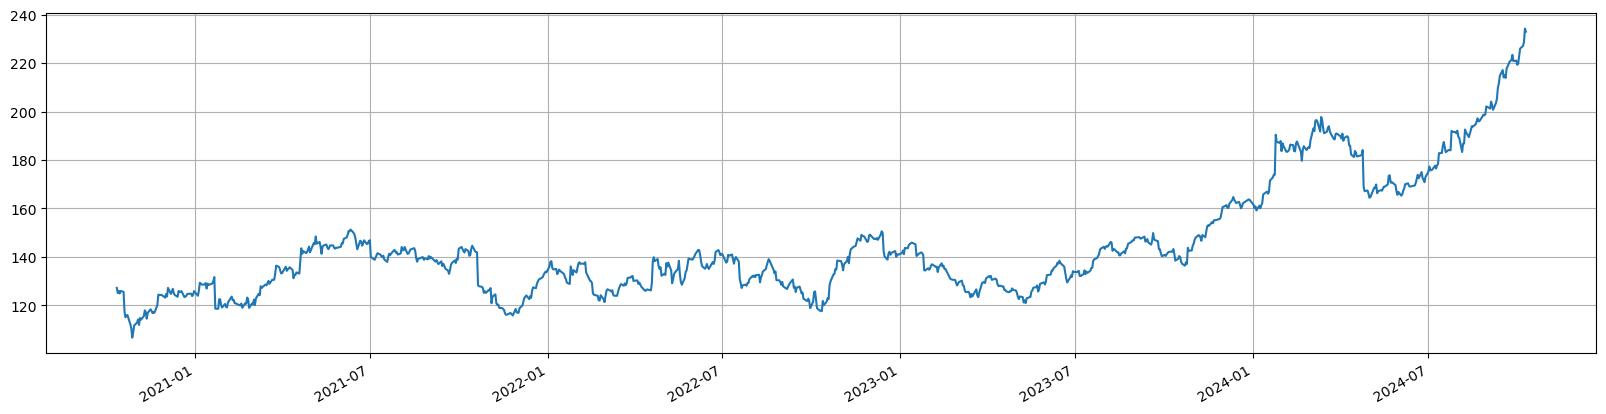

2020-10-12    127.21
2020-10-13    125.10
2020-10-14    125.94
2020-10-15    124.89
2020-10-16    125.93
               ...  
2024-10-04    226.00
2024-10-07    227.12
2024-10-08    228.62
2024-10-09    234.30
2024-10-10    233.02
Name: close, Length: 1006, dtype: float64


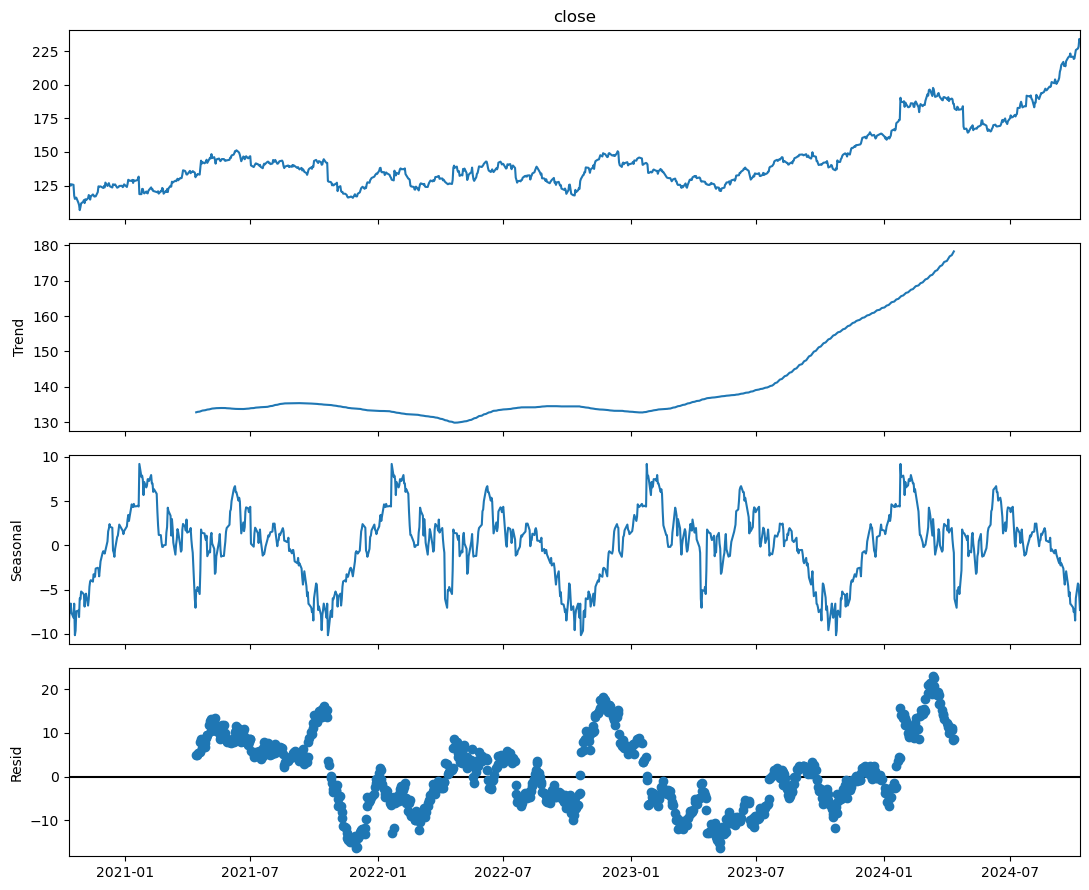

In [9]:
z=x['2020-10-10':'2024-10-10']
z.plot(grid=True,figsize=(20,5))
plt.show()
#plotted time series and seasonal decomposition with 252 which is market days
print(z)
rcParams['figure.figsize']=(11,9)
decomposition=sm.tsa.seasonal_decompose(z, model = 'additive',period=252,) 
fig = decomposition.plot()
plt.show()

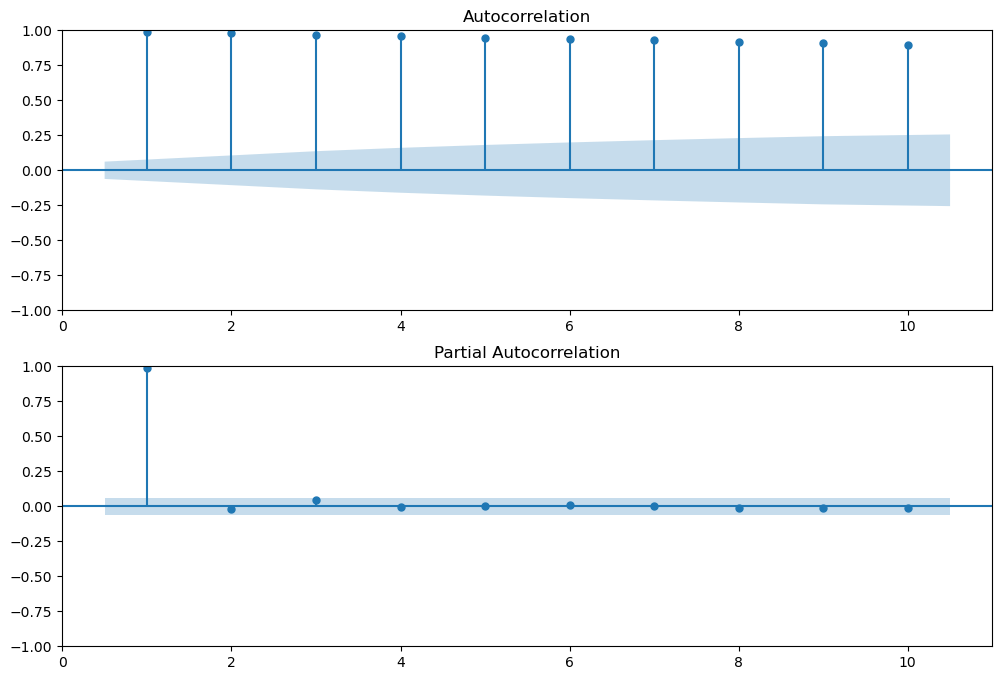

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 #pacf and acf plots
plot_acf(z,lags=10, zero=False, ax=ax1)
plot_pacf(z,lags=10, zero=False, ax=ax2)

plt.show()


In [11]:
import numpy as np


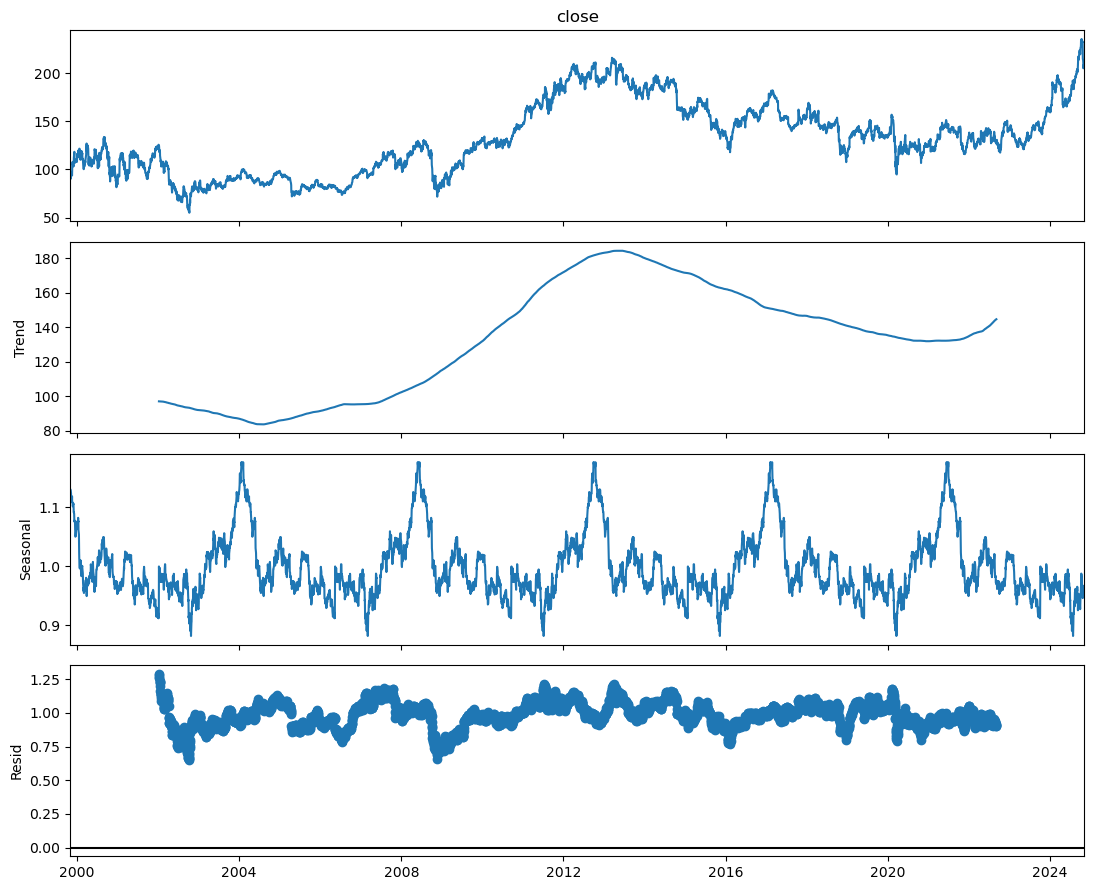

In [13]:
rcParams['figure.figsize']=(11,9)
#three year period
decomposition=sm.tsa.seasonal_decompose(x, model = 'multiplicative',period=1095,) 
fig = decomposition.plot()
plt.show()

In [26]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
#stationarity test
def obtain_adf_kpss_results(timeseries,max_d):   
    results=[]
    for idx in range(max_d):
        adf_result = adfuller(timeseries, autolag='AIC')
        kpss_result = kpss(timeseries, regression='c', nlags="auto")
        timeseries = timeseries.diff().dropna()
        if adf_result[1] <=0.05:
            adf_stationary = True
        else:
            adf_stationary = False
        if kpss_result[1] <=0.05:
            kpss_stationary = False
        else:
            kpss_stationary = True
            
        stationary = adf_stationary & kpss_stationary
            
        results.append((idx,adf_result[1], kpss_result[1],adf_stationary,kpss_stationary, stationary))
    results_df = pd.DataFrame(results, columns=['d','adf_stats','p-value', 'is_adf_stationary','is_kpss_stationary','is_stationary' ])
    
    return results_df

In [27]:
obtain_adf_kpss_results(x,3)

/state/partition1/job-53253979/ipykernel_2357504/215609685.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries, regression='c', nlags="auto")
/state/partition1/job-53253979/ipykernel_2357504/215609685.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(timeseries, regression='c', nlags="auto")
/state/partition1/job-53253979/ipykernel_2357504/215609685.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(timeseries, regression='c', nlags="auto")


,d,adf_stats,p-value,is_adf_stationary,is_kpss_stationary,is_stationary
0,0,6.756244e-01,0.01,False,False,False
1,1,3.100597e-30,0.10,True,True,True
2,2,0.000000e+00,0.10,True,True,True


In [28]:
url = 'https://alphavantageapi.co/timeseries/running_analytics?SYMBOLS=AAPL,IBM&RANGE=2month&INTERVAL=DAILY&OHLC=close&WINDOW_SIZE=7&CALCULATIONS=STDDEV&apikey=demo'

/state/partition1/job-53253979/ipykernel_2357504/776240613.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z['month-year'] = z.index.to_period('M')


<Axes: title={'center': 'Five number Summary of Prices per Month for a 4 year window'}, xlabel='month-year', ylabel='close'>

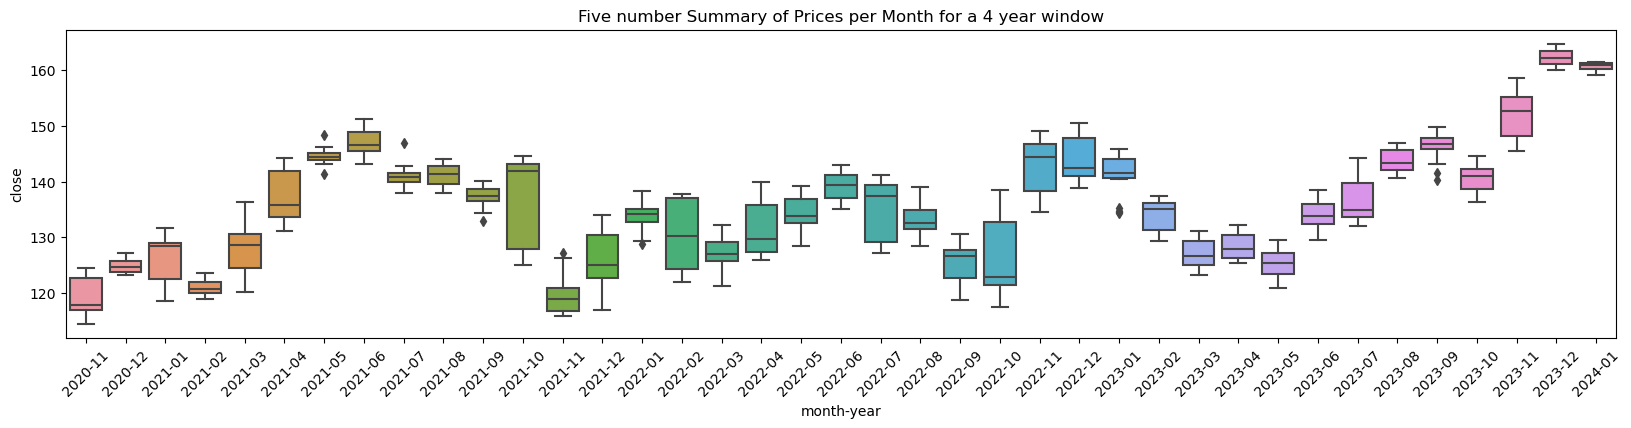

In [33]:
import seaborn as sns
#box plot of series
z=Z['2020-11-10':'2024-01-10']
z['month-year'] = z.index.to_period('M')
plt.figure(figsize=(20,4))
plt.xticks(rotation=45)
plt.title('Five number Summary of Prices per Month for a 4 year window')
sns.boxplot(x="month-year", y="close", data=z)

In [35]:
import yfinance as yf

# Download the S&P 500 Technology sector index
sp500_tech = yf.download('^GSPC', start='1999-11-01', end='2024-10-13')
sp500_tech.rename(columns={'Close': 'sp_500close'}, inplace=True)
sp=sp500_tech['sp_500close']


[*********************100%***********************]  1 of 1 completed


In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import Perceptron
from sklearn.utils import shuffle
from sklearn.utils import resample
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [ ]:
#get data
a=pd.read_csv('IBM.csv')
a.drop(columns=['7_day_std',
       '7_SMA', '14_EMA', 'DMI_plus', 'DMI_minus', 'ATR', 'MACD',
       'MACD_Signal', 'stoch_k', 'stoch_d', 'close_change'], inplace=True)
a['Unnamed: 0'] = pd.to_datetime(a['Unnamed: 0'])
a.set_index('Unnamed: 0', inplace=True)
a = a[a.index.isin(df.index)]

In [55]:
import pmdarima as pm
import pandas as pd

In [56]:
#arimax
model = pm.auto_arima(merged_df['close'], X=exog, start_p=1, start_q=1, 
                              max_p=5, max_q=5, 
                              seasonal=False, 
                              stepwise=True, 
                              trace=True, 
                              suppress_warnings=True,
                              error_action='ignore', 
                              maxiter=100)

summary = model.summary()
print(summary)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=26620.534, Time=1.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=26619.648, Time=1.69 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=26618.565, Time=0.94 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=26618.577, Time=1.00 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=26620.544, Time=1.20 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=26625.588, Time=0.84 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=26620.480, Time=0.71 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 7.614 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 6290
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -13304.282
Date:                Fri, 13 Dec 2024   AIC                          26618.565
Time:                        16:02:58   BIC                          26652.298
Sample:         

In [166]:
print(a['close'])

Unnamed: 0
1999-11-02     94.81
1999-11-03     94.37
1999-11-04     91.56
1999-11-05     90.25
1999-11-08     93.94
               ...  
2024-10-25    214.67
2024-10-28    212.91
2024-10-29    210.43
2024-10-30    204.90
2024-10-31    206.72
Name: close, Length: 6290, dtype: float64


In [261]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import numpy as np
#get predictions and residuals
from sklearn.metrics import explained_variance_score
dat=pd.read_csv('exog.csv')
diff=pd.read_csv('diff.csv')
df=dat.dropna()

df.iloc[:,0] = pd.to_datetime(df.iloc[:,0], errors='coerce')
df.set_index(df.columns[0], inplace=True)
df.drop(columns=df.columns[0], inplace=True)
diff.iloc[:,0] = pd.to_datetime(diff.iloc[:,0], errors='coerce')
diff.set_index(diff.columns[0], inplace=True)
merged_df = df.merge(diff, left_index=True, right_index=True, how='inner')
d=merged_df.drop('close',axis=1, inplace=False)
train_size = int(len(df) * 0.8)
trainset,testset = a['close'][:train_size],a['close'][train_size:]
exog = d
exog_train=exog[:train_size]
test_index='2019-11-01'
arimax = SARIMAX(a['close'], exog=exog, order=(1, 0, 0), seasonal_order=(0, 0, 0, 0))
model = arimax.fit()
exog_test=exog[train_size:]
prediction = model.predict(start=0, end=-1, exog=exog)
prediction2=model.forecast(1258, exog=exog_test)
prediction2.index=testset.index
residuals = testset - prediction2
residuals_df = pd.DataFrame({'Residuals': residuals})

/var/folders/sw/z1pq8bn92ms8vtnzf3rkgfzh0000gn/T/ipykernel_74676/3826046396.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:,0] = pd.to_datetime(df.iloc[:,0], errors='coerce')
/var/folders/sw/z1pq8bn92ms8vtnzf3rkgfzh0000gn/T/ipykernel_74676/3826046396.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:,0] = pd.to_datetime(df.iloc[:,0], errors='coerce')
/var/folders/sw/z1pq8bn92ms8vtnzf3rkgfzh0000gn/T/ipykernel_74676/3826046396.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.68985D+00    |proj g|=  1.00242D-01

At iterate    5    f=  3.00739D+00    |proj g|=  8.21825D-02

At iterate   10    f=  2.85231D+00    |proj g|=  3.34505D-02

At iterate   15    f=  2.72403D+00    |proj g|=  6.16043D-01

At iterate   20    f=  2.04756D+00    |proj g|=  9.07082D-01

At iterate   25    f=  2.03834D+00    |proj g|=  1.50568D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     50      1     0     0   

/Users/marieqi/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/marieqi/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [262]:
print(residuals_df)

            Residuals
Unnamed: 0           
2019-11-01  43.494920
2019-11-04  45.313995
2019-11-05  45.534791
2019-11-06  46.427544
2019-11-07  44.982115
...               ...
2024-10-25   8.172151
2024-10-28   6.606520
2024-10-29   2.320207
2024-10-30  -0.942208
2024-10-31   0.955682

[1258 rows x 1 columns]


In [206]:
df=merged_df
print(df)

            treasury_yield    ^SP500-45  interest_rate  close
Unnamed: 0                                                   
1999-11-02            5.14   605.990723           5.18  -1.94
1999-11-03            5.12   615.300232           5.21  -0.44
1999-11-04            5.10   621.889954           5.27  -2.81
1999-11-05            5.14   629.349609           5.14  -1.31
1999-11-08            5.20   635.789246           5.23   3.69
...                    ...          ...            ...    ...
2024-10-25            4.73  4534.910156           4.83  -3.72
2024-10-28            4.70  4531.649902           4.83  -1.76
2024-10-29            4.70  4582.229980           4.83  -2.48
2024-10-30            4.67  4520.939941           4.83  -5.53
2024-10-31            4.64  4520.939941           4.83   1.82

[6290 rows x 4 columns]


In [88]:


print(df)
print(a)

              open      high       low   close    volume
Unnamed: 0                                              
1999-11-01   98.50   98.8100   96.3700   96.75   9551800
1999-11-02   96.75   96.8100   93.6900   94.81  11105400
1999-11-03   95.87   95.9400   93.5000   94.37  10369100
1999-11-04   94.44   94.4400   90.0000   91.56  16697600
1999-11-05   92.75   92.9400   90.1900   90.25  13737600
...            ...       ...       ...     ...       ...
2024-11-04  207.65  207.7000  205.8000  206.32   2594119
2024-11-05  206.17  208.1150  205.5700  207.57   2441535
2024-11-06  213.48  214.3300  210.3700  213.60   3934386
2024-11-07  213.64  214.5199  211.9300  213.69   3675812
2024-11-08  214.16  216.7000  212.7809  213.72   3201038

[6297 rows x 5 columns]
            treasury_yield    ^SP500-45  interest_rate  close
Unnamed: 0                                                   
1999-11-02            5.14   605.990723           5.18  -1.94
1999-11-03            5.12   615.300232         

In [266]:
train_size = int(len(residuals_df) * 0.8)
from torch.utils.data import DataLoader, TensorDataset
d=merged_df.drop('close',axis=1,inplace=False)
trains=int(len(d)*.8)
d=d[trains:]
#ANN architecture
X_train,X_test = d[:train_size], d[train_size:]
Y_train,Y_test = residuals_df['Residuals'][:train_size], residuals_df['Residuals'][train_size:]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size, dropout_prob, activation):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.dropout_prob = dropout_prob
        if activation =='relu':
            self.activation = nn.ReLU()  
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        else :
            self.activation = nn.ReLU()
            print("Activation function not implemented, using default ReLU")
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), 
            self.activation,
            nn.Dropout(p=dropout_prob),
            nn.Linear(n_hidden, n_hidden), 
            self.activation,
            nn.Dropout(p=dropout_prob),
            nn.Linear(n_hidden, output_size)
        )

    def forward(self, x):
        return self.network(x)


def train_model(model, train_loader, optimizer, num_epochs):
    model.train()
    criterion = nn.MSELoss()
    for epoch in range(num_epochs):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

def test_model(model, test_loader):
    model.eval()
    test_loss = 0.0
    criterion = nn.MSELoss()
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
    mse_loss = test_loss / len(test_loader)
    return mse_loss
 

def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

def predict(model, test_loader, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            predictions.append(output.squeeze().cpu().numpy())   
    predictions = np.concatenate(predictions)
    
    return pd.Series(predictions)
def initialize_weights_xavier(layer):
    if isinstance(layer, nn.Linear):
        nn.init.xavier_uniform_(layer.weight)
        if layer.bias is not None:
            nn.init.zeros_(layer.bias)

def initialize_weights_normal(layer):
    if isinstance(layer, nn.Linear):
        nn.init.normal_(layer.weight, mean=0.0, std=0.02)
        if layer.bias is not None:
            nn.init.zeros_(layer.bias)

def initialize_weights_uniform(layer):
    if isinstance(layer, nn.Linear):
        nn.init.uniform_(layer.weight, a=-0.1, b=0.1)
        if layer.bias is not None:
            nn.init.zeros_(layer.bias)
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)  # Convert DataFrame to tensor
Y_train_tensor = torch.tensor(Y_train.values, dtype=torch.float32)  # Convert Series to tensor


if len(Y_train_tensor.shape) == 1:
    Y_train_tensor = Y_train_tensor.unsqueeze(1) 


train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test.values, dtype=torch.float32)
if len(Y_test_tensor.shape) == 1:
    Y_test_tensor = Y_test_tensor.unsqueeze(1)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

input_size=3
output_size=1
n_hidden=5
torch.cuda.empty_cache()
model_fnn=FC2Layer(input_size, n_hidden, output_size,  0.2, 'sigmoid')
model_fnn=model_fnn.to(device)

model_fnn.apply(initialize_weights_xavier)
optimizer = optim.Adam(model_fnn.parameters(), lr=0.03567 )
train_model(model_fnn, train_loader, optimizer, num_epochs=10)
test_loss=test_model(model_fnn, test_loader)
print(f'Final Test Loss:{test_loss}')
pred=predict(model_fnn,test_loader,device)

Epoch [1/10], Loss: 58.5269
Epoch [2/10], Loss: 48.1973
Epoch [3/10], Loss: 74.3653
Epoch [4/10], Loss: 77.4553
Epoch [5/10], Loss: 74.3513
Epoch [6/10], Loss: 77.9651
Epoch [7/10], Loss: 70.3955
Epoch [8/10], Loss: 77.3946
Epoch [9/10], Loss: 75.2463
Epoch [10/10], Loss: 76.2689
Final Test Loss:239.06269653141499


In [274]:
#Change the test set now 252 20% of the first test set
prediction2=prediction2[1006:]
pred.index=prediction2.index

MAPE: 7.868%
MPE: -5.668%
RMSE: 17.704
Explained Variance: 0.483
MAE 13.925


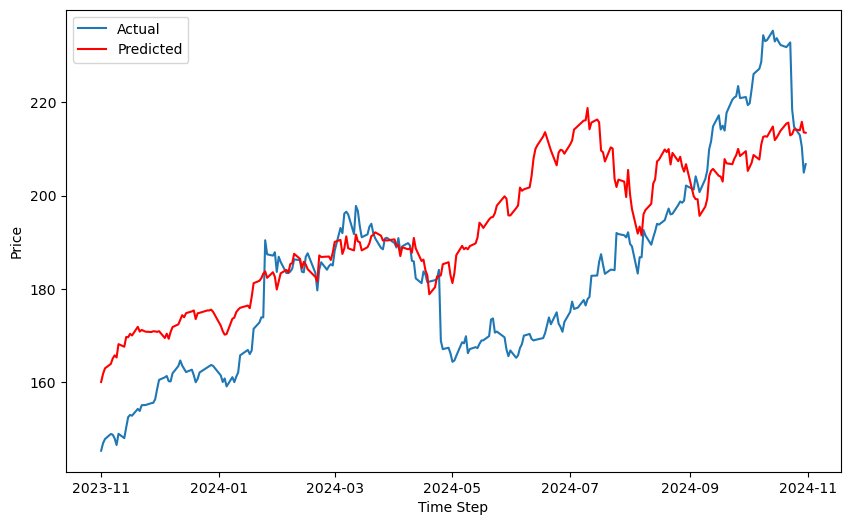

In [276]:
#print metrics
ans1=prediction2+pred

actual=testset[1006:]
residuals=actual-ans1

mae = np.mean(np.abs(residuals))

mape = np.mean(np.abs(residuals) / (actual+1e-6)) * 100 
mpe = np.mean(residuals / (actual +1e-6 )) * 100 
rmse = np.sqrt(np.mean((residuals) ** 2))
explained_var=explained_variance_score(actual, ans1)
print(f"MAPE: {mape:.3f}%")
print(f"MPE: {mpe:.3f}%")
print(f"RMSE: {rmse:.3f}")
print(f"Explained Variance: {explained_var:.3f}")
print('MAE %.3f'%mae)
plt.figure(figsize=(10, 6))
plt.plot(prediction2.index, actual, label="Actual")
plt.plot(prediction2.index,ans1, label="Predicted", color='red')
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.show()

In [279]:
!pip install -U "ray[data,train,tune,serve]"

  Obtaining dependency information for ray[data,serve,train,tune] from https://files.pythonhosted.org/packages/a9/fc/811e88c982ea755c6351bd5f2c410cd8526695069a708d9aa3c9410a8dc3/ray-2.40.0-cp311-cp311-macosx_10_15_x86_64.whl.metadata
  Obtaining dependency information for fastapi from https://files.pythonhosted.org/packages/52/b3/7e4df40e585df024fac2f80d1a2d579c854ac37109675db2b0cc22c0bb9e/fastapi-0.115.6-py3-none-any.whl.metadata
  Obtaining dependency information for watchfiles from https://files.pythonhosted.org/packages/24/a8/06e2d5f840b285718a09be7c71ea19b7177b005cec87b8923dd7e8541b20/watchfiles-1.0.3-cp311-cp311-macosx_10_12_x86_64.whl.metadata
  Obtaining dependency information for pydantic!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,<3 from https://files.pythonhosted.org/packages/62/51/72c18c55cf2f46ff4f91ebcc8f75aa30f7305f3d726be3f4ebffb4ae972b/pydantic-2.10.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 12.5 MB/s eta 0:00:00
  Obtaining depe

In [268]:
#use feature selection to find smaller mse does not work
from autofeat import FeatureSelector
import pandas as pd
from autofeat import AutoFeatRegressor
selector = FeatureSelector(verbose=1)
X_selected = selector.fit_transform(X_train, Y_train)
autofeat = AutoFeatRegressor(verbose=1, featsel_runs=5)
X_train_feat = autofeat.fit_transform(X_train, Y_train)
X_test_feat = autofeat.transform(X_test)
X_train_tensor = torch.tensor(X_train_feat.values, dtype=torch.float32)  # Convert DataFrame to tensor
Y_train_tensor = torch.tensor(Y_train.values, dtype=torch.float32)  # Convert Series to tensor


if len(Y_train_tensor.shape) == 1:
    Y_train_tensor = Y_train_tensor.unsqueeze(1) 


train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
X_test_tensor = torch.tensor(X_test_feat.values, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test.values, dtype=torch.float32)
if len(Y_test_tensor.shape) == 1:
    Y_test_tensor = Y_test_tensor.unsqueeze(1)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

input_size=6
output_size=1
n_hidden=2
torch.cuda.empty_cache()
model_fnn=FC2Layer(input_size, n_hidden, output_size, .2, 'sigmoid')
model_fnn=model_fnn.to(device)

model_fnn.apply(initialize_weights_xavier)
optimizer = optim.Adam(model_fnn.parameters(), lr=0.001)
train_model(model_fnn, train_loader, optimizer, num_epochs=10)
test_loss=test_model(model_fnn, test_loader)
print(test_loss)


2024-12-17 22:19:52,461 INFO: [featsel] Feature selection run 1/5
2024-12-17 22:19:52,491 INFO: [featsel] Feature selection run 2/5
2024-12-17 22:19:52,515 INFO: [featsel] Feature selection run 3/5
2024-12-17 22:19:52,543 INFO: [featsel] Feature selection run 4/5
2024-12-17 22:19:52,564 INFO: [featsel] Feature selection run 5/5
2024-12-17 22:19:52,583 INFO: [featsel] 3 features after 5 feature selection runs
2024-12-17 22:19:52,584 INFO: [featsel] 2 features after correlation filtering
2024-12-17 22:19:52,590 INFO: [featsel] 2 features after noise filtering
2024-12-17 22:19:52,592 INFO: [AutoFeat] The 2 step feature engineering process could generate up to 231 features.
2024-12-17 22:19:52,592 INFO: [AutoFeat] With 1006 data points this new feature matrix would use about 0.00 gb of space.
2024-12-17 22:19:52,593 INFO: [feateng] Step 1: transformation of original features


[featsel] Scaling data...done.


2024-12-17 22:19:53,287 INFO: [feateng] Generated 15 transformed features from 3 original features - done.
2024-12-17 22:19:53,288 INFO: [feateng] Step 2: first combination of features
2024-12-17 22:19:53,434 INFO: [feateng] Generated 145 feature combinations from 153 original feature tuples - done.
2024-12-17 22:19:53,436 INFO: [feateng] Generated altogether 162 new features in 2 steps
2024-12-17 22:19:53,436 INFO: [feateng] Removing correlated features, as well as additions at the highest level
2024-12-17 22:19:53,440 INFO: [feateng] Generated a total of 25 additional features
2024-12-17 22:19:53,441 INFO: [featsel] Feature selection run 1/5
2024-12-17 22:19:53,551 INFO: [featsel] Feature selection run 2/5


[featsel] Scaling data...done.        153 feature tuples combined


2024-12-17 22:19:53,673 INFO: [featsel] Feature selection run 3/5
2024-12-17 22:19:53,819 INFO: [featsel] Feature selection run 4/5
2024-12-17 22:19:53,959 INFO: [featsel] Feature selection run 5/5
2024-12-17 22:19:54,090 INFO: [featsel] 15 features after 5 feature selection runs
2024-12-17 22:19:54,091 INFO: [featsel] 9 features after correlation filtering
2024-12-17 22:19:54,109 INFO: [featsel] 4 features after noise filtering
2024-12-17 22:19:54,110 INFO: [AutoFeat] Computing 3 new features.
2024-12-17 22:19:54,292 INFO: [AutoFeat]     3/    3 new features ...done.
2024-12-17 22:19:54,293 INFO: [AutoFeat] Final dataframe with 6 feature columns (3 new).
2024-12-17 22:19:54,293 INFO: [AutoFeat] Training final regression model.
2024-12-17 22:19:54,298 INFO: [AutoFeat] Trained model: largest coefficients:
2024-12-17 22:19:54,298 INFO: 77.98308919672931
2024-12-17 22:19:54,299 INFO: -0.033535 * exp(interest_rate)
2024-12-17 22:19:54,299 INFO: -0.029015 * ^SP500-45
2024-12-17 22:19:54,300

Epoch [1/10], Loss: 699.2341eatures
Epoch [2/10], Loss: 1196.7937
Epoch [3/10], Loss: 120.8388
Epoch [4/10], Loss: 1166.3279
Epoch [5/10], Loss: 573.9531
Epoch [6/10], Loss: 126.8196
Epoch [7/10], Loss: 897.0624
Epoch [8/10], Loss: 201.3166
Epoch [9/10], Loss: 111.3976
Epoch [10/10], Loss: 194.2583
256.4202254265547


In [270]:
originalfeat= X_train.columns.tolist()
new = [feat for feat in X_train_feat.columns if feat not in originalfeat]
print(new)

['exp(interest_rate)', 'exp(interest_rate)/interest_rate', 'treasury_yield/interest_rate']


In [272]:
selector = FeatureSelector(verbose=1)
X_selected = selector.fit_transform(X_train, Y_train)
X_test_selected = X_test[X_selected.columns]
X_train_tensor = torch.tensor(X_selected.values, dtype=torch.float32)  # Convert DataFrame to tensor
Y_train_tensor = torch.tensor(Y_train.values, dtype=torch.float32)  # Convert Series to tensor


if len(Y_train_tensor.shape) == 1:
    Y_train_tensor = Y_train_tensor.unsqueeze(1) 


train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
X_test_tensor = torch.tensor(X_test_selected.values, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test.values, dtype=torch.float32)
if len(Y_test_tensor.shape) == 1:
    Y_test_tensor = Y_test_tensor.unsqueeze(1)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

input_size=2
output_size=1
n_hidden=5
torch.cuda.empty_cache()
model_fnn=FC2Layer(input_size, n_hidden, output_size, 0.2292, 'sigmoid')
model_fnn=model_fnn.to(device)

model_fnn.apply(initialize_weights_xavier)
optimizer = optim.Adam(model_fnn.parameters(), lr=0.01)
train_model(model_fnn, train_loader, optimizer, num_epochs=5)
test_loss=test_model(model_fnn, test_loader)
print(test_loss)
pred=predict(model_fnn,test_loader,device)

2024-12-17 22:20:17,611 INFO: [featsel] Feature selection run 1/5
2024-12-17 22:20:17,641 INFO: [featsel] Feature selection run 2/5
2024-12-17 22:20:17,664 INFO: [featsel] Feature selection run 3/5
2024-12-17 22:20:17,687 INFO: [featsel] Feature selection run 4/5
2024-12-17 22:20:17,707 INFO: [featsel] Feature selection run 5/5
2024-12-17 22:20:17,725 INFO: [featsel] 3 features after 5 feature selection runs
2024-12-17 22:20:17,726 INFO: [featsel] 2 features after correlation filtering
2024-12-17 22:20:17,732 INFO: [featsel] 2 features after noise filtering


[featsel] Scaling data...done.
Epoch [1/5], Loss: 586.5305
Epoch [2/5], Loss: 189.9279
Epoch [3/5], Loss: 116.0236
Epoch [4/5], Loss: 178.9853
Epoch [5/5], Loss: 47.6161
309.12332702055573


In [37]:
!pip install Autofeat n_hidden=5
torch.cuda.empty_cache()
model_fnn=FC2Layer(input_size, n_hidden, output_size,  0.21308, 'tanh')
model_fnn=model_fnn.to(device)

model_fnn.apply(initialize_weights_xavier)
optimizer = optim.Adam(model_fnn.parameters(), lr=0.03567 )
train_model(model_fnn, train_loader, optimizer, num_epochs=5)

  Obtaining dependency information for Autofeat from https://files.pythonhosted.org/packages/43/eb/24f2d208af6b124d3d352e03039f120e7303d902a5b153c94cef2900b747/autofeat-2.1.3-py3-none-any.whl.metadata
  Obtaining dependency information for pint<1.0,>=0.17 from https://files.pythonhosted.org/packages/b7/16/bd2f5904557265882108dc2e04f18abc05ab0c2b7082ae9430091daf1d5c/Pint-0.24.4-py3-none-any.whl.metadata
  Obtaining dependency information for flexcache>=0.3 from https://files.pythonhosted.org/packages/27/cd/c883e1a7c447479d6e13985565080e3fea88ab5a107c21684c813dba1875/flexcache-0.3-py3-none-any.whl.metadata
  Obtaining dependency information for flexparser>=0.4 from https://files.pythonhosted.org/packages/fe/5e/3be305568fe5f34448807976dc82fc151d76c3e0e03958f34770286278c1/flexparser-0.4-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 10.6 MB/s eta 0:00:00
